# Clustering analysis using appraisal theory to derive facial expressions

The purpose of this analysis is to derive facial expression from data based on psychologically meaningful annotations, and then use these facial factors to train a classifier to predict outcomes.  This analysis is inspired by Stratou et al (2017) and Hoegen et al (2023), but draw from appraisal theory of emotions to form meaningful emotions clusters.  Using appraisals to understanding facial expressions in not new, and work is done by both Ong et all (2021) or Houlihan et al (2022), Houlihan et al (2023).

In [1]:
##### Standard packages
import numpy as np
import pandas as pd
import os
import math
import random
import re

# scipy
import scipy
import scipy.spatial.distance

##### Plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

##### Clustering 
# Dynamic time warping
from dtaidistance import dtw
import dtaidistance.clustering
from tslearn import barycenters

# factor analysis
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# Decision trees and random forrests
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier

## metrics 
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score

## misc
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE # oversampling for imbalanced datasets


##### Saving 
import pickle


## Data loading and cleaning

First thing we do is that we find all relevant participant and file names

Now we load all the files

In [2]:
d_au_annotation_unfiltered = pd.read_csv("../data/d_au_annotation.csv")
d_au_annotation_unfiltered.rename(columns=lambda x: x[:-2] if x.endswith("_r") else x, inplace=True)

## Factor analysis for all participants

First we add factors from the factor analysis conducted in R

In [3]:
d_au_control = d_au_annotation_unfiltered.query("~(control_self != control_self)").copy() # remove na

# define the factors
f1 = ["AU06", "AU07", "AU09", "AU10"]
f1_weights = [0.854, 0.712, 0.302, 0.735]
f2 = ["AU01", "AU02"]
f2_weights = [0.986, 0.800]
f3 = ["AU15", "AU17"]
f3_weights = [0.324, 0.991]
f4 = ["AU12", "AU14"]
f4_weights = [0.776, 0.458]
f5 = ["AU25", "AU26"]
f5_weights = [0.781, 0.689]
f6 = ["AU23"]
f6_weights = [0.817]
f7 = ["AU09", "AU15"]
f7_weights = [0.304, 0.328]


# Create expressivity metrics
# # mean activation
# d_au_control["f1_mean"]  = d_au_control[f1].mean(axis=1)
# d_au_control["f2_mean"]  = d_au_control[f2].mean(axis=1)
# d_au_control["f3_mean"]  = d_au_control[f3].mean(axis=1)
# d_au_control["f4_mean"]  = d_au_control[f4].mean(axis=1)
# d_au_control["f5_mean"]  = d_au_control[f5].mean(axis=1)
# d_au_control["f6_mean"]  = d_au_control[f6].mean(axis=1)
# d_au_control["f7_mean"]  = d_au_control[f7].mean(axis=1)

# weighted mean activation
d_au_control["f1_mean"]  = d_au_control[f1].mul(f1_weights).sum(axis=1)/len(f1)
d_au_control["f2_mean"]  = d_au_control[f2].mul(f2_weights).sum(axis=1)/len(f2)
d_au_control["f3_mean"]  = d_au_control[f3].mul(f3_weights).sum(axis=1)/len(f3)
d_au_control["f4_mean"]  = d_au_control[f4].mul(f4_weights).sum(axis=1)/len(f4)
d_au_control["f5_mean"]  = d_au_control[f5].mul(f5_weights).sum(axis=1)/len(f5)
d_au_control["f6_mean"]  = d_au_control[f6].mul(f6_weights).sum(axis=1)/len(f6)
d_au_control["f7_mean"]  = d_au_control[f7].mul(f7_weights).sum(axis=1)/len(f7)

# # sum variables
# d_au_control["f1_sum"]  = d_au_control[f1].sum(axis=1)
# d_au_control["f2_sum"]  = d_au_control[f2].sum(axis=1)
# d_au_control["f3_sum"]  = d_au_control[f3].sum(axis=1)
# d_au_control["f4_sum"]  = d_au_control[f4].sum(axis=1)
# d_au_control["f5_sum"]  = d_au_control[f5].sum(axis=1)
# d_au_control["f6_sum"]  = d_au_control[f6].sum(axis=1)
# d_au_control["f7_sum"]  = d_au_control[f7].sum(axis=1)

# weighted sum variables
d_au_control["f1_sum"]  = d_au_control[f1].mul(f1_weights).sum(axis=1)
d_au_control["f2_sum"]  = d_au_control[f2].mul(f2_weights).sum(axis=1)
d_au_control["f3_sum"]  = d_au_control[f3].mul(f3_weights).sum(axis=1)
d_au_control["f4_sum"]  = d_au_control[f4].mul(f4_weights).sum(axis=1)
d_au_control["f5_sum"]  = d_au_control[f5].mul(f5_weights).sum(axis=1)
d_au_control["f7_sum"]  = d_au_control[f7].mul(f7_weights).sum(axis=1)


# # sd
# d_au_control["f1_sd"]  = d_au_control[f1].std(axis=1)
# d_au_control["f2_sd"]  = d_au_control[f2].std(axis=1)
# d_au_control["f3_sd"]  = d_au_control[f3].std(axis=1)
# d_au_control["f4_sd"]  = d_au_control[f4].std(axis=1)
# d_au_control["f5_sd"]  = d_au_control[f5].std(axis=1)
# d_au_control["f6_sd"]  = 0 # as it's only one AU
# d_au_control["f7_sd"]  = d_au_control[f7].std(axis=1)

# sd
d_au_control["f1_sd"]  = d_au_control[f1].mul(f1_weights).std(axis=1)
d_au_control["f2_sd"]  = d_au_control[f2].mul(f2_weights).std(axis=1)
d_au_control["f3_sd"]  = d_au_control[f3].mul(f3_weights).std(axis=1)
d_au_control["f4_sd"]  = d_au_control[f4].mul(f4_weights).std(axis=1)
d_au_control["f5_sd"]  = d_au_control[f5].mul(f5_weights).std(axis=1)
d_au_control["f7_sd"]  = d_au_control[f7].mul(f7_weights).std(axis=1)


# change variables
d_au_control["f1_change"]  = d_au_control["f1_mean"].diff().fillna(0)
d_au_control["f2_change"]  = d_au_control["f2_mean"].diff().fillna(0)
d_au_control["f3_change"]  = d_au_control["f3_mean"].diff().fillna(0)
d_au_control["f4_change"]  = d_au_control["f4_mean"].diff().fillna(0)
d_au_control["f5_change"]  = d_au_control["f5_mean"].diff().fillna(0)
d_au_control["f6_change"]  = d_au_control["f6_mean"].diff().fillna(0)
d_au_control["f7_change"]  = d_au_control["f7_mean"].diff().fillna(0)

# max
# d_au_control["f1_max"]  = d_au_control[f1].max(axis=1)
# d_au_control["f2_max"]  = d_au_control[f2].max(axis=1)
# d_au_control["f3_max"]  = d_au_control[f3].max(axis=1)
# d_au_control["f4_max"]  = d_au_control[f4].max(axis=1)
# d_au_control["f5_max"]  = d_au_control[f5].max(axis=1)
# d_au_control["f6_max"]  = d_au_control[f6].max(axis=1)
# d_au_control["f7_max"]  = d_au_control[f7].max(axis=1)
# max
d_au_control["f1_max"]  = d_au_control[f1].mul(f1_weights).max(axis=1)
d_au_control["f2_max"]  = d_au_control[f2].mul(f2_weights).max(axis=1)
d_au_control["f3_max"]  = d_au_control[f3].mul(f3_weights).max(axis=1)
d_au_control["f4_max"]  = d_au_control[f4].mul(f4_weights).max(axis=1)
d_au_control["f5_max"]  = d_au_control[f5].mul(f5_weights).max(axis=1)
d_au_control["f7_max"]  = d_au_control[f7].mul(f7_weights).max(axis=1)




# Random Forests

In [4]:
# Base model
X = d_au_control.copy()
y = d_au_control["control_self"]
average_classification = []
f1_score_list = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

    #Predict the response for test dataset
    y_pred = ["Medium"] * len(y_test)

    average_classification.append(metrics.accuracy_score(y_test, y_pred))
    
    # Calculate F1 score for each class separately

    # f1_per_class = f1_score(y_test, y_pred, average=None)
    # print(f1_per_class)

    # Calculate micro-average F1 score
    # f1_micro = f1_score(y_test, y_pred, average='micro')

    # Calculate macro-average F1 score
    # f1_macro = f1_score(y_test, y_pred, average='macro')

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))

print(np.mean(average_classification))
print(np.mean(f1_score_list))

Accuracy: 0.38330095994144636
F1: 0.21241888807516368
Accuracy: 0.38468034794358585
F1: 0.21373737312552252
Accuracy: 0.3795287560172283
F1: 0.20882794362306994
Accuracy: 0.3812178025504603
F1: 0.21043315936567136
Accuracy: 0.3775863525040115
F1: 0.20698732001537953
Accuracy: 0.38256903977704587
F1: 0.21172045082035526
Accuracy: 0.3824001351237227
F1: 0.21155938809215177
Accuracy: 0.37468682262196323
F1: 0.2042504703417087
Accuracy: 0.3809644455704755
F1: 0.2101921005342973
Accuracy: 0.3788531374039355
F1: 0.20818707348490903
0.3805787799453875
0.20983141674782294


### AU model

In [5]:
#split dataset in features and target variable
feature_cols_au = [col_name for col_name in d_au_control.columns if "au" in col_name.lower()]
X_au = d_au_control[feature_cols_au] # Features
y_au = d_au_control["control_self"] # Target variable


X_train_au, X_test_au, y_train_au, y_test_au = train_test_split(X_au, y_au, test_size=0.3, random_state=1) # 70% training and 30% test

In [29]:
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_au)))]}

rf = RandomForestClassifier()

grid_seach_au = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_au.fit(X_train_au, y_train_au)

print(grid_seach_au.best_params_)
print(grid_seach_au.score(X_train_au, y_train_au))
best_rf_au = grid_seach_au.best_estimator_

KeyboardInterrupt: 

In [7]:
print(grid_seach_au.best_params_)
print(grid_seach_au.score(X_train_au, y_train_au))
best_rf_au = grid_seach_au.best_estimator_

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.6903865643550021


In [47]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_au))), random_state=1)

average_classification_au = []
f1_score_list_au = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au, y_au, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_au.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_au.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_au))
print(np.mean(f1_score_list_au))

Accuracy: 0.6532105959519184
F1: 0.6498166578130674
Accuracy: 0.6609802100047857
F1: 0.6575309600879283
Accuracy: 0.6618810348225094
F1: 0.6582194163000902
Accuracy: 0.6610928131070011
F1: 0.6572991438037118
Accuracy: 0.663429327477972
F1: 0.6596297822559265
Accuracy: 0.6662725558089125
F1: 0.6620696294414179
Accuracy: 0.6609239084536779
F1: 0.6572370210669112
Accuracy: 0.6589252033893533
F1: 0.6552346143930943
Accuracy: 0.6605016468203699
F1: 0.6566518863063432
Accuracy: 0.6670889282999747
F1: 0.6634596532218274
0.6614306224136475
0.6577148764690317


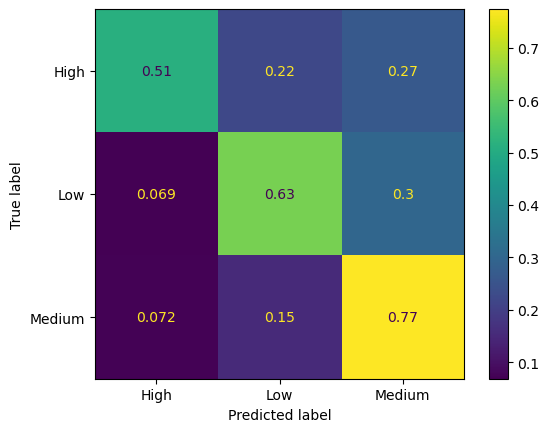

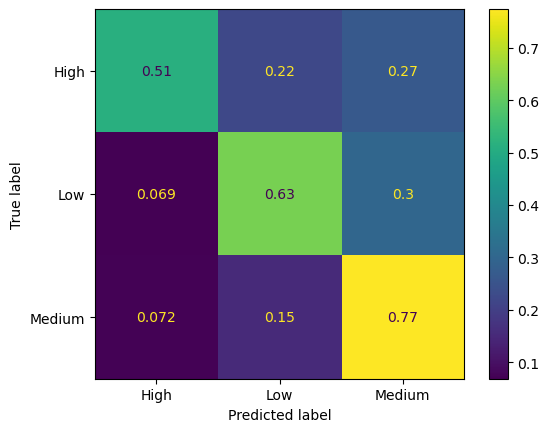

In [ ]:
y_pred = best_rf_au.predict(X_test_au)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_au, y_pred, normalize="true").plot()

<Axes: >

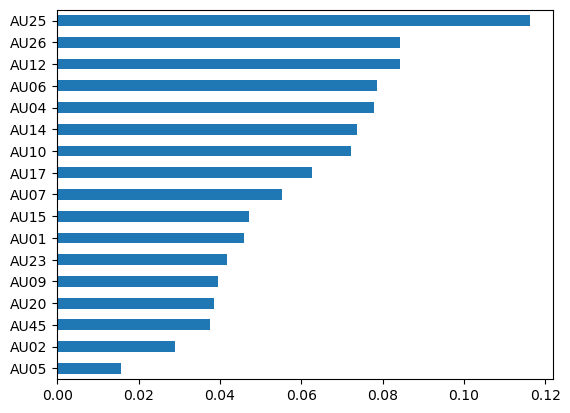

In [10]:
feature_importance_au = pd.Series(best_rf_au.feature_importances_, index=X_train_au.columns).sort_values(ascending=True)
feature_importance_au.plot.barh()

In [11]:
#split dataset in features and target variable

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f_full = re.compile(r"f\d+_(mean|sum|sd|change|max)")

# Extract matching column names
feature_cols_f_full = [col_name for col_name in d_au_control.columns if pattern_f_full.match(col_name)]
X_ff = d_au_control[feature_cols_f_full] # Features
y_ff = d_au_control["control_self"] # Target variable


X_train_ff, X_test_ff, y_train_ff, y_test_ff = train_test_split(X_ff, y_ff, test_size=0.3, random_state=1) # 70% training and 30% test

In [12]:
# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f_full)))]}

rf = RandomForestClassifier()

grid_seach_ff = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_ff.fit(X_train_ff, y_train_ff)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': [4, 6, 8, 10],
                         'max_features': [5], 'n_estimators': [10, 30, 50]},
             scoring='accuracy')

In [13]:
print(grid_seach_ff.best_params_)
print(grid_seach_ff.score(X_train_ff, y_train_ff))
best_rf_ff = grid_seach_ff.best_estimator_

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 5, 'n_estimators': 50}
0.6292408667535351


In [14]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f_full))), random_state=1)

average_classification_ff = []
f1_score_list_ff = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_ff, y_ff, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_ff.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_ff.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_ff))
print(np.mean(f1_score_list_ff))

Accuracy: 0.5958956169242463
F1: 0.5909157815733105
Accuracy: 0.59890774990851
F1: 0.5944357573789941
Accuracy: 0.5968527432930777
F1: 0.5926161174757291
Accuracy: 0.5947695859020916
F1: 0.5907628565468426
Accuracy: 0.5975283619063705
F1: 0.5933645554051861
Accuracy: 0.5920108098978127
F1: 0.5874852334818323
Accuracy: 0.5949947921065225
F1: 0.5903962192915212
Accuracy: 0.5991048053373871
F1: 0.5946108310725832
Accuracy: 0.5981476789685556
F1: 0.5939051235522922
Accuracy: 0.5988514483574022
F1: 0.5939836502652379
0.5967063592601975
0.5922476126043529


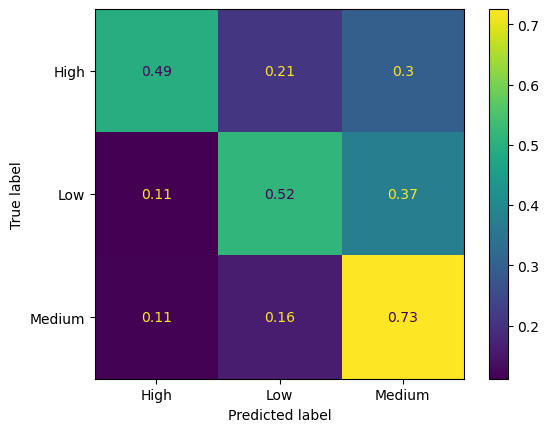

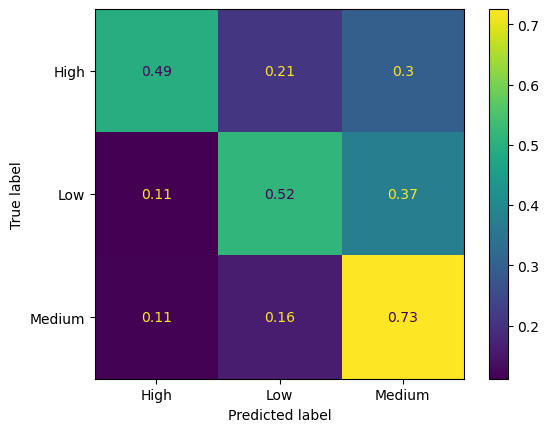

In [15]:
y_pred = best_rf_ff.predict(X_test_ff)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_ff, y_pred, normalize="true").plot()
plt.show()

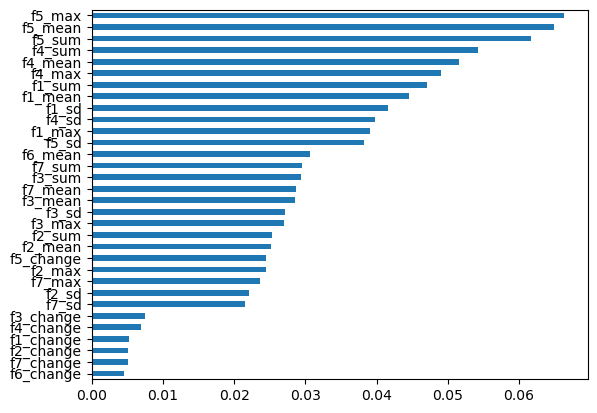

Index(['f6_change', 'f7_change', 'f2_change', 'f1_change', 'f4_change',
       'f3_change', 'f7_sd', 'f2_sd', 'f7_max', 'f2_max', 'f5_change',
       'f2_mean', 'f2_sum', 'f3_max', 'f3_sd', 'f3_mean', 'f7_mean', 'f3_sum',
       'f7_sum', 'f6_mean', 'f5_sd', 'f1_max', 'f4_sd', 'f1_sd', 'f1_mean',
       'f1_sum', 'f4_max', 'f4_mean', 'f4_sum', 'f5_sum', 'f5_mean', 'f5_max'],
      dtype='object')


In [16]:
feature_importance_ff = pd.Series(best_rf_ff.feature_importances_, index=X_train_ff.columns).sort_values(ascending=True)
feature_importance_ff.plot.barh()

plt.show()
print(feature_importance_ff.index)

In [12]:
#split dataset in features and target variable

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f = re.compile(r"f\d+_(mean|sum|sd|max)")

# Extract matching column names
feature_cols_f = [col_name for col_name in d_au_control.columns if pattern_f.match(col_name)]
X_f = d_au_control[feature_cols_f] # Features
y_f = d_au_control["control_self"] # Target variable


X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.3, random_state=1) # 70% training and 30% test

In [18]:
# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f)))]}

rf = RandomForestClassifier()
# #£££#wdsdljsldj 
grid_seach_f = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f.fit(X_train_f, y_train_f)
print(grid_seach_f.best_params_)
print(grid_seach_f.score(X_train_f, y_train_f))
best_rf_f = grid_seach_f.best_estimator_

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': [4, 6, 8, 10],
                         'max_features': [5], 'n_estimators': [10, 30, 50]},
             scoring='accuracy')

In [19]:
print(grid_seach_f.best_params_)
print(grid_seach_f.score(X_train_f, y_train_f))
best_rf_f = grid_seach_f.best_estimator_

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 5, 'n_estimators': 50}
0.6420298248154047


In [50]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f))))

average_classification_f = []
f1_score_list_f = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f))
print(np.mean(f1_score_list_f))

Accuracy: 0.6088731244545788
F1: 0.6053124981170868
Accuracy: 0.6165582861807842
F1: 0.6126754411153146
Accuracy: 0.6163612307519072
F1: 0.6126346049315559
Accuracy: 0.610280663232272
F1: 0.6066344882693007
Accuracy: 0.6125890268276891
F1: 0.6086548053408452
Accuracy: 0.6087042198012556
F1: 0.6047225423000807
Accuracy: 0.611772654336627
F1: 0.6076369116134087
Accuracy: 0.6156574613630605
F1: 0.6123309061674571
Accuracy: 0.6204430932072179
F1: 0.6169849475969212
Accuracy: 0.6131520423387664
F1: 0.6097813751031627
0.6134391802494159
0.6097368520555133


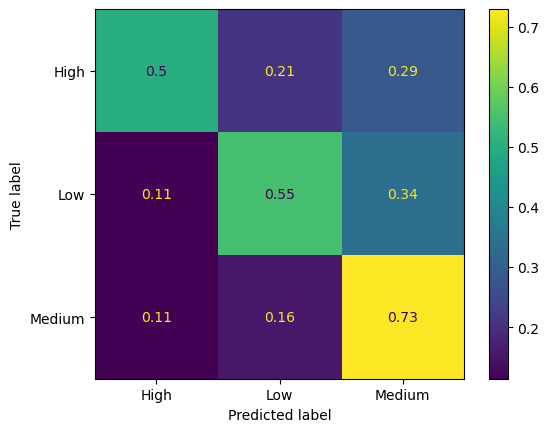

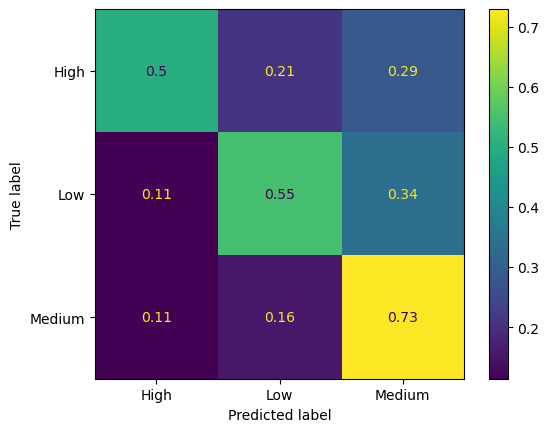

In [21]:
y_pred = best_rf_f.predict(X_test_f)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f, y_pred, normalize="true").plot()

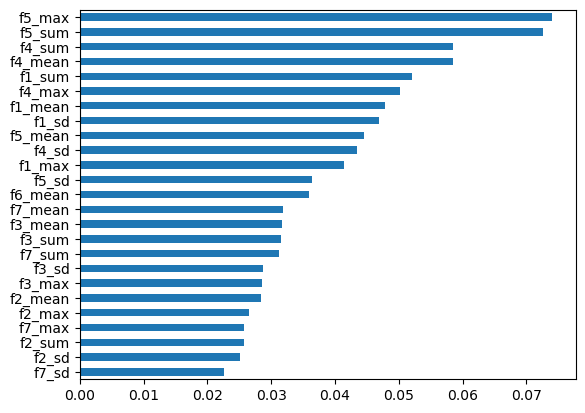

Index(['f7_sd', 'f2_sd', 'f2_sum', 'f7_max', 'f2_max', 'f2_mean', 'f3_max',
       'f3_sd', 'f7_sum', 'f3_sum', 'f3_mean', 'f7_mean', 'f6_mean', 'f5_sd',
       'f1_max', 'f4_sd', 'f5_mean', 'f1_sd', 'f1_mean', 'f4_max', 'f1_sum',
       'f4_mean', 'f4_sum', 'f5_sum', 'f5_max'],
      dtype='object')


In [22]:
feature_importance_f = pd.Series(best_rf_f.feature_importances_, index=X_train_f.columns).sort_values(ascending=True)
feature_importance_f.plot.barh()

plt.show()
print(feature_importance_f.index)

## SMOTE (oversampling)

##### AU oversampling

In [6]:
smote=SMOTE(sampling_strategy="auto")
print(y_au.value_counts())
X_au_smote, y_au_smote = smote.fit_resample(X_au, y_au)
print(y_au_smote.value_counts())



control_self
Medium    44932
Low       40744
High      32731
Name: count, dtype: int64
control_self
Low       44932
High      44932
Medium    44932
Name: count, dtype: int64


In [6]:
# Au oversampling
X_train_au_smote, X_test_au_smote, y_train_au_smote, y_test_au_smote = train_test_split(X_au_smote, y_au_smote, test_size=0.3, random_state=1) # 70% training and 30% test

In [7]:
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_au)))]}

rf = RandomForestClassifier()

grid_seach_au_smote = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_au_smote.fit(X_train_au_smote, y_train_au_smote)

print(grid_seach_au_smote.best_params_)
print(grid_seach_au_smote.score(X_train_au_smote, y_train_au_smote))
best_rf_au_smote = grid_seach_au_smote.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.6980086268109414


In [13]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_au))), random_state=1)

average_classification_au_smote = []
f1_score_list_au_smote = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au_smote, y_au_smote, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_au_smote.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_au_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_au_smote))
print(np.mean(f1_score_list_au_smote))

Accuracy: 0.6547145082717178
F1: 0.6550771111036242
Accuracy: 0.6548876084967482
F1: 0.654993654794409
Accuracy: 0.651252503771112
F1: 0.6515329966680445
Accuracy: 0.6565938821434754
F1: 0.6568459080032132
Accuracy: 0.6560745814683845
F1: 0.6563530721854735
Accuracy: 0.6556047380004452
F1: 0.6557350579568797
Accuracy: 0.6590172852938995
F1: 0.6592620115775686
Accuracy: 0.6526125769677786
F1: 0.6527551813812481
Accuracy: 0.6536264497143847
F1: 0.65398024227179
Accuracy: 0.6636909913697173
F1: 0.6638890987334338
0.6558075125497662
0.6560424334675685


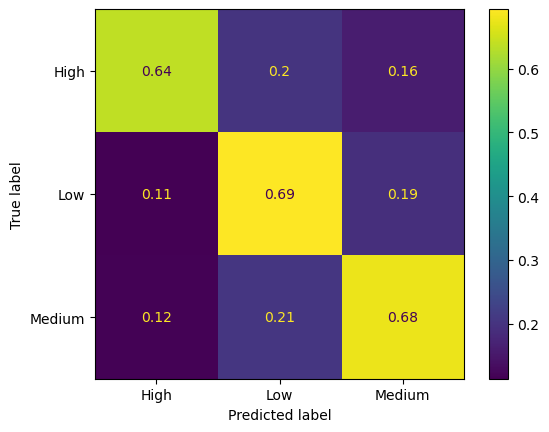

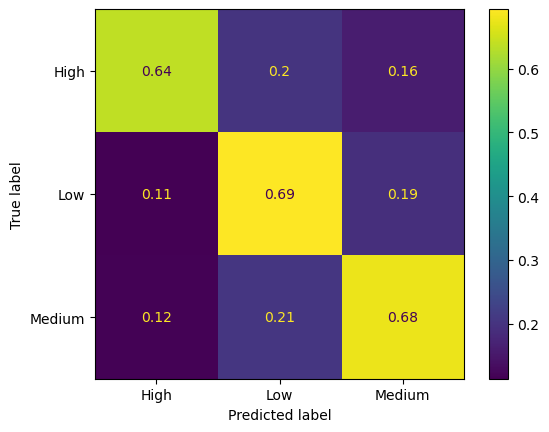

<Axes: >

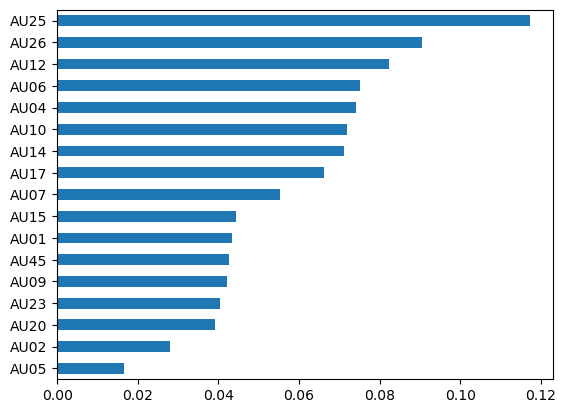

In [9]:
y_pred = best_rf_au_smote.predict(X_test_au_smote)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_au_smote, y_pred, normalize="true").plot()
plt.show()
feature_importance_au_smote = pd.Series(best_rf_au_smote.feature_importances_, index=X_train_au.columns).sort_values(ascending=True)
feature_importance_au_smote.plot.barh()

### BASE model

In [10]:
average_classification_smote = []
f1_score_list_smote = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au_smote, y_au_smote, test_size=0.3) # 70% training and 30% test

    #Predict the response for test dataset
    y_pred = ["Medium"] * len(y_test)

    average_classification_smote.append(metrics.accuracy_score(y_test, y_pred))
    
    # Calculate F1 score for each class separately

    # f1_per_class = f1_score(y_test, y_pred, average=None)
    # print(f1_per_class)

    # Calculate micro-average F1 score
    # f1_micro = f1_score(y_test, y_pred, average='micro')

    # Calculate macro-average F1 score
    # f1_macro = f1_score(y_test, y_pred, average='macro')

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))

print(np.mean(average_classification_smote))
print(np.mean(f1_score_list_smote))

Accuracy: 0.3328964613368283
F1: 0.16628456475821907
Accuracy: 0.3355918791265857
F1: 0.16864719095082004
Accuracy: 0.33141274512228297
F1: 0.16498926877765405
Accuracy: 0.3317836741759193
F1: 0.16531274347958666
Accuracy: 0.3320062316081011
F1: 0.1655069401492756
Accuracy: 0.3348005638121615
F1: 0.16795230773473843
Accuracy: 0.3358391651623433
F1: 0.1688645576479002
Accuracy: 0.3336135908405252
F1: 0.16691195824326077
Accuracy: 0.3310912732757981
F1: 0.164709112651024
Accuracy: 0.3332426617868889
F1: 0.16658733600074616
0.33322782462474343
0.1665765980393225


### Factor subset

In [23]:
# Create the factors on the smote'd dataset
X_f_smote = X_au_smote.copy()
y_f_smote = y_au_smote.copy()

# weighted mean activation
X_f_smote["f1_mean"]  = X_f_smote[f1].mul(f1_weights).sum(axis=1)/len(f1)
X_f_smote["f2_mean"]  = X_f_smote[f2].mul(f2_weights).sum(axis=1)/len(f2)
X_f_smote["f3_mean"]  = X_f_smote[f3].mul(f3_weights).sum(axis=1)/len(f3)
X_f_smote["f4_mean"]  = X_f_smote[f4].mul(f4_weights).sum(axis=1)/len(f4)
X_f_smote["f5_mean"]  = X_f_smote[f5].mul(f5_weights).sum(axis=1)/len(f5)
X_f_smote["f6_mean"]  = X_f_smote[f6].mul(f6_weights).sum(axis=1)/len(f6)
X_f_smote["f7_mean"]  = X_f_smote[f7].mul(f7_weights).sum(axis=1)/len(f7)

# weighted sum variables
X_f_smote["f1_sum"]  = X_f_smote[f1].mul(f1_weights).sum(axis=1)
X_f_smote["f2_sum"]  = X_f_smote[f2].mul(f2_weights).sum(axis=1)
X_f_smote["f3_sum"]  = X_f_smote[f3].mul(f3_weights).sum(axis=1)
X_f_smote["f4_sum"]  = X_f_smote[f4].mul(f4_weights).sum(axis=1)
X_f_smote["f5_sum"]  = X_f_smote[f5].mul(f5_weights).sum(axis=1)
X_f_smote["f7_sum"]  = X_f_smote[f7].mul(f7_weights).sum(axis=1)


# sd
X_f_smote["f1_sd"]  = X_f_smote[f1].mul(f1_weights).std(axis=1)
X_f_smote["f2_sd"]  = X_f_smote[f2].mul(f2_weights).std(axis=1)
X_f_smote["f3_sd"]  = X_f_smote[f3].mul(f3_weights).std(axis=1)
X_f_smote["f4_sd"]  = X_f_smote[f4].mul(f4_weights).std(axis=1)
X_f_smote["f5_sd"]  = X_f_smote[f5].mul(f5_weights).std(axis=1)
X_f_smote["f7_sd"]  = X_f_smote[f7].mul(f7_weights).std(axis=1)

# max
X_f_smote["f1_max"]  = X_f_smote[f1].mul(f1_weights).max(axis=1)
X_f_smote["f2_max"]  = X_f_smote[f2].mul(f2_weights).max(axis=1)
X_f_smote["f3_max"]  = X_f_smote[f3].mul(f3_weights).max(axis=1)
X_f_smote["f4_max"]  = X_f_smote[f4].mul(f4_weights).max(axis=1)
X_f_smote["f5_max"]  = X_f_smote[f5].mul(f5_weights).max(axis=1)
X_f_smote["f7_max"]  = X_f_smote[f7].mul(f7_weights).max(axis=1)

X_f_smote = X_f_smote[feature_cols_f]

In [15]:
X_train_f_smote, X_test_f_smote, y_train_f_smote, y_test_f_smote = train_test_split(X_f_smote, y_f_smote, test_size=0.3, random_state=1) # 70% training and 30% test

# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f)))]}

rf = RandomForestClassifier()

grid_seach_f_smote = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f_smote.fit(X_train_f_smote, y_train_f_smote)

# best parameters
print(grid_seach_f_smote.best_params_)
print(grid_seach_f_smote.score(X_train_f_smote, y_train_f_smote))
best_rf_f_smote = grid_seach_f_smote.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 50}
0.6505293724895874


In [16]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f))))

average_classification_f_smote = []
f1_score_list_f_smote = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f_smote, y_f_smote, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f_smote.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f_smote))
print(np.mean(f1_score_list_f_smote))


Accuracy: 0.6223200375874774
F1: 0.6222349036362209
Accuracy: 0.6197977200227504
F1: 0.6197741292580843
Accuracy: 0.6222211231731745
F1: 0.622081147675868
Accuracy: 0.6185860184475382
F1: 0.618439711818692
Accuracy: 0.6197729914191745
F1: 0.6197022896854804
Accuracy: 0.6212319790301442
F1: 0.6212000470960459
Accuracy: 0.6223200375874774
F1: 0.622251317142135
Accuracy: 0.6193278765548109
F1: 0.6190516281285552
Accuracy: 0.6211577932194169
F1: 0.6210721554741762
Accuracy: 0.6193773337619625
F1: 0.6193019407458585
0.6206112910803927
0.6205109270661117


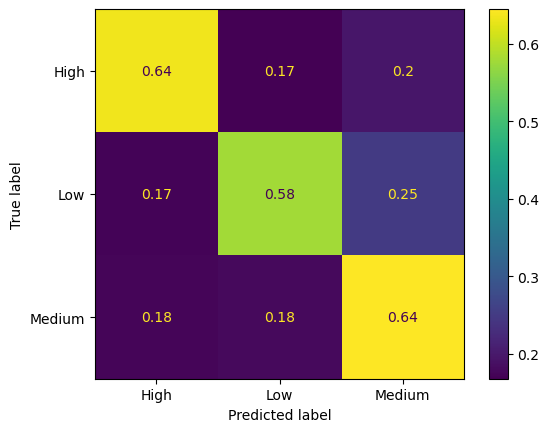

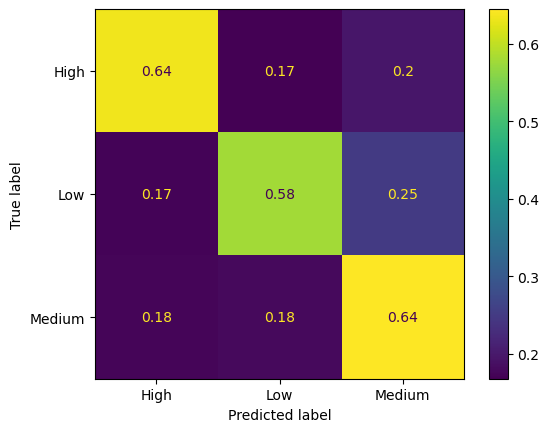

<Axes: >

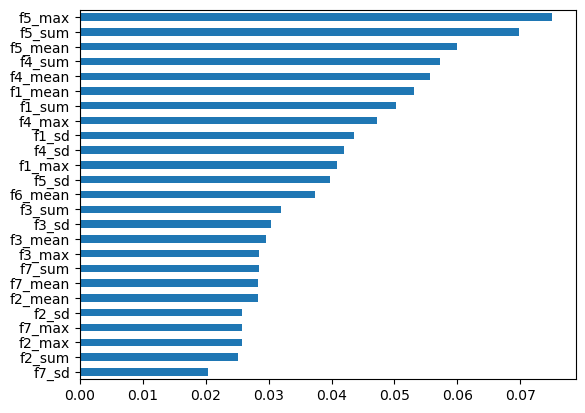

In [17]:
y_pred = best_rf_f_smote.predict(X_test_f_smote)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f_smote, y_pred, normalize="true").plot()
plt.show()
feature_importance_f_smote = pd.Series(best_rf_f_smote.feature_importances_, index=X_train_f_smote.columns).sort_values(ascending=True)
feature_importance_f_smote.plot.barh()

In [21]:
print(list(feature_importance_au_smote))

[0.016490137145388488, 0.02805084570725775, 0.03907909202320244, 0.040411701145889115, 0.04203659350461894, 0.04250977647921853, 0.04337311211802373, 0.044447042305981094, 0.0551990295433165, 0.066089173307346, 0.07114878246848244, 0.07190293959149537, 0.07420195577790754, 0.0751708215271029, 0.0822206940854503, 0.09043568069716515, 0.11723262257215376]


## Stratou

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.6669563466409487
Accuracy: 0.6340661242859615
F1: 0.634456104409783
Accuracy: 0.6341155814931131
F1: 0.6344923572330455
Accuracy: 0.6311481490640224
F1: 0.6314324848533771
Accuracy: 0.6292440465886892
F1: 0.6295791599358431
Accuracy: 0.6342639531145676
F1: 0.6346119012926132
Accuracy: 0.6376765004080219
F1: 0.6380074403711057
Accuracy: 0.6323598506392344
F1: 0.6325856602544208
Accuracy: 0.6289967605529315
F1: 0.6293648274691408
Accuracy: 0.6326071366749919
F1: 0.6330216469852347
Accuracy: 0.6277603303741438
F1: 0.6279887680054217
0.6322238433195676
0.6325540350809986


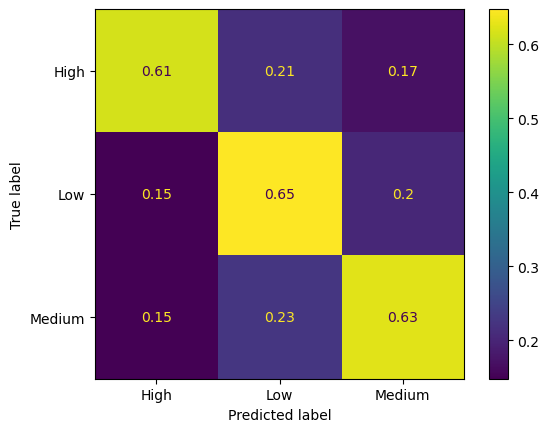

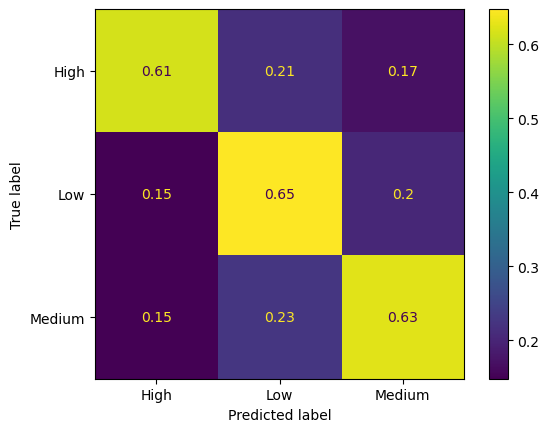

<Axes: >

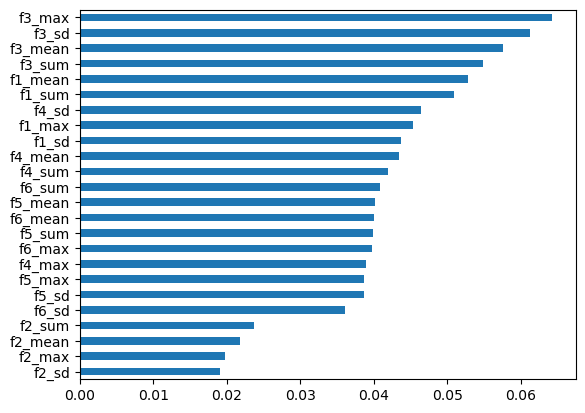

In [7]:
f1_strat = ["AU06", "AU07", "AU12"]
f1_weights_strat = [0.982, 0.446, 0.882]
f2_strat = ["AU01", "AU02"]
f2_weights_strat = [0.981, 0.873]
f3_strat = ["AU20", "AU25", "AU26"]
f3_weights_strat = [0.377, 0.951, 0.786]
f4_strat = ["AU14", "AU17", "AU23"]
f4_weights_strat = [0.724, 0.632, 0.710]
f5_strat = ["AU04", "AU07", "AU09"]
f5_weights_strat = [0.703, 0.384, 0.390]
f6_strat = ["AU10", "AU15", "AU17"]
f6_weights_strat = [0.488, 0.504, 0.420]

# Create the factors on the smote'd dataset
X_f_smote_strat = X_au_smote.copy()
y_f_smote_strat = y_au_smote.copy()

# weighted mean activation
X_f_smote_strat["f1_mean"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).sum(axis=1)/len(f1_strat)
X_f_smote_strat["f2_mean"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).sum(axis=1)/len(f2_strat)
X_f_smote_strat["f3_mean"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).sum(axis=1)/len(f3_strat)
X_f_smote_strat["f4_mean"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).sum(axis=1)/len(f4_strat)
X_f_smote_strat["f5_mean"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).sum(axis=1)/len(f5_strat)
X_f_smote_strat["f6_mean"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).sum(axis=1)/len(f6_strat)

# weighted sum variables
X_f_smote_strat["f1_sum"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).sum(axis=1)
X_f_smote_strat["f2_sum"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).sum(axis=1)
X_f_smote_strat["f3_sum"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).sum(axis=1)
X_f_smote_strat["f4_sum"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).sum(axis=1)
X_f_smote_strat["f5_sum"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).sum(axis=1)
X_f_smote_strat["f6_sum"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).sum(axis=1)


# sd
X_f_smote_strat["f1_sd"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).std(axis=1)
X_f_smote_strat["f2_sd"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).std(axis=1)
X_f_smote_strat["f3_sd"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).std(axis=1)
X_f_smote_strat["f4_sd"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).std(axis=1)
X_f_smote_strat["f5_sd"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).std(axis=1)
X_f_smote_strat["f6_sd"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).std(axis=1)

# max
X_f_smote_strat["f1_max"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).max(axis=1)
X_f_smote_strat["f2_max"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).max(axis=1)
X_f_smote_strat["f3_max"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).max(axis=1)
X_f_smote_strat["f4_max"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).max(axis=1)
X_f_smote_strat["f5_max"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).max(axis=1)
X_f_smote_strat["f6_max"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).max(axis=1)

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f_strat = re.compile(r"f\d+_(mean|sum|sd|max)")

# Extract matching column names
feature_cols_f_strat = [col_name for col_name in X_f_smote_strat.columns if pattern_f_strat.match(col_name)]

X_f_smote_strat = X_f_smote_strat[feature_cols_f_strat]

# divide 
X_train_f_smote_strat, X_test_f_smote_strat, y_train_f_smote_strat, y_test_f_smote_strat = train_test_split(X_f_smote_strat, y_f_smote_strat, test_size=0.3, random_state=1) # 70% training and 30% test

# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f_strat)))]}

rf = RandomForestClassifier()

grid_seach_f_smote_strat = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f_smote_strat.fit(X_train_f_smote_strat, y_train_f_smote_strat)

# best parameters
print(grid_seach_f_smote_strat.best_params_)
print(grid_seach_f_smote_strat.score(X_train_f_smote_strat, y_train_f_smote_strat))
best_rf_f_smote_strat = grid_seach_f_smote_strat.best_estimator_


# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f_strat))))

average_classification_f_smote_strat = []
f1_score_list_f_smote_strat = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f_smote_strat, y_f_smote_strat, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f_smote_strat.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f_smote_strat.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f_smote_strat))
print(np.mean(f1_score_list_f_smote_strat))

# plots
y_pred = best_rf_f_smote_strat.predict(X_test_f_smote_strat)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f_smote_strat, y_pred, normalize="true").plot()
plt.show()
feature_importance_f_smote_strat = pd.Series(best_rf_f_smote_strat.feature_importances_, index=X_train_f_smote_strat.columns).sort_values(ascending=True)
feature_importance_f_smote_strat.plot.barh()

In [10]:
print(list(feature_importance_f_smote_strat))

[0.019021744610932367, 0.01979708956863626, 0.021775914432399436, 0.023701209590687475, 0.03603393284995201, 0.03863699089568017, 0.03865013423935222, 0.038997661088222675, 0.03978659985868629, 0.03984979127131145, 0.03997715719508615, 0.04013369094334502, 0.04085106547641898, 0.04188244736687314, 0.04349990909106514, 0.043721304146244595, 0.045335932563415116, 0.04645294512142578, 0.05088416116824198, 0.05287992324706663, 0.05490599913653369, 0.05765263364933102, 0.061258446420389356, 0.06431331606870302]
